# Analysis of Paleo-present Climate Data
***

## Background
Paleoclimatology is the study of the climate history of earth [1]. This science allows for a better understanding of the climate of Earth in the past and how it relates to present and future climates on the planet. Earths climate past cannot be found in modern records. Therefore, scientists must gather data preserved in nature over the millennia in paleological remains referred to as proxy records [1]. An example of a type of proxy data is when scientists drill into ice sheets and extract ice cores to analyse deposits trapped within the ice, such as pollen and gas [1]. This gives insights into the atmospheric and climatic conditions that existed when particular layers of the sheet formed. These studies have shown that the climate of Earth is always changing. Research revealed that there have been several ice ages as well as several periods of global warming [1]. An ice age is a period of colder global temperatures and recurring glacial expansion capable of lasting hundreds of millions of years [2]. Paleoclimatology has shown that other enviromental factors such as continental drift, greenhouses gases in the atmosphere, solar energy, and the variation in Earth’s orbit have all affected the climate of Earth over time. This type of science is vital to our understanding of climate on Earth. Models can be developed to help predict how increased carbon dioxide levels and other changes may impact the climate of Earth in years to come.

***

In [88]:
# Import necessary libraries.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.dates import YearLocator, DateFormatter
from sklearn.preprocessing import PolynomialFeatures

## Data Processing

### CO2 Data
The CO2 data being analysed is a composite dataset derived from Antartic ice cores. The dataset spans over a timeframe of 800,000 years before the present (yrBP) to the year 2001, where 1950 is the present date. This composite, presented by Bereiter et al. in 2014, revises the earlier Lüthi et al. (2008) version. The  atmospheric CO2 concentrations is measured in parts per million by volume (ppmv) at various points in time. The age unit is measured in years before present.  

In [2]:
# Load CO2 data.
co2_data = pd.read_excel('data/new_atmospheric_CO2.xls', sheet_name='CO2 Composite', skiprows=range(14))

In [3]:
co2_data.head()

,Gasage (yr BP),CO2 (ppmv),sigma mean CO2 (ppmv)
0,-51.030000,368.022488,0.060442
1,-48.000000,361.780737,0.370000
2,-46.279272,359.647793,0.098000
3,-44.405642,357.106740,0.159923
4,-43.080000,353.946685,0.043007


In [4]:
# Remove extra spaces from column names.
co2_data.columns = co2_data.columns.str.strip()

In [5]:
# Extract relevant columns.
co2_df = co2_data[['Gasage (yr BP)', 'CO2 (ppmv)']]

### Mauna Loa Data
The Mauna Loa data has the the latest anthropogenic data. Since 1958, the atmospheric carbon dioxide (CO2) concentration measurements were collected at the Mauna Loa Observatory in Hawaii. The observatory is in prime location to sample the Earths air. It is situated on the side of Mauna Loa, the world’s largest active volcano. The observatory is approximately 3,400 meters above sea level and remains a long distance away from significant pollution sources [4]. This means the air is relatively clean. The Mauna Loa Observatory allows scientists to understand the ongoing increase in greenhouse gas concentrations. The measurements are essential for assessing  the impact of human-induced climate change on the Earth's atmosphere. National Oceanic and Atmospheric Administration (NOAA) maintained the dataset.

In [6]:
# Load Mauna Loa data [3].
# https://www.geeksforgeeks.org/how-to-skip-rows-while-reading-csv-file-using-pandas/
mauna_loa_data = pd.read_csv('data/mlo_data.csv',
                             skiprows = [i for i in range(1, 44)])

In [7]:
mauna_loa_data.head()

,year,mean,unc
0,2002,373.45,0.12
1,2003,375.98,0.12
2,2004,377.70,0.12
3,2005,379.98,0.12
4,2006,382.09,0.12


The Mauna Loa data and the historical Antarctic ice core records must be merged to allow for a comprehensive analysis of the long-term trends in atmospheric CO2 concentrations. In order to merge the datasets, a few adjustments had to be made to the Mauna Loa data. This was to ensure  compatibility between the two datasets. Specifically, the age unit was aligned by calculating the *'Gasage (yr BP)'* column to match the reference year of 1950, facilitating a seamless integration of the two datasets. Additionally, the *mean* column in the Mauna Loa data was renamed to *'CO2 (ppmv)'* for consistency with the Antarctic ice core data.

In [8]:
# Adjustments of Mauna Loa data required to merge datasets.
# Age unit adjustment.
reference_year = 1950
mauna_loa_data['Gasage (yr BP)'] = reference_year - mauna_loa_data['year']

# Convert 'Gasage (yr BP)' to float in the dataframe
mauna_loa_data['Gasage (yr BP)'] = mauna_loa_data['Gasage (yr BP)'].astype(float)

# Rename column to match CO2 dataset.
# https://stackoverflow.com/questions/46066685/rename-the-column-inside-csv-file
mauna_loa_data = mauna_loa_data.rename(columns=({'mean':'CO2 (ppmv)'}))

# Extract relevant columns.
mlo_data = mauna_loa_data[['Gasage (yr BP)', 'CO2 (ppmv)']]

### Merging CO2 Data and Mauna Loa Data

In [9]:
# Merge CO2 data and Mauna Loa data.
merged_data = pd.concat([mlo_data, co2_df[['Gasage (yr BP)', 'CO2 (ppmv)']]])

### Temperature
A temperature anomly is the difference between a temperauture and an average temperature [5]. The average temperature is usually referred to as the baseline temperature. The baseline temperature choosen depends on the size of the dataset. Generally, a common approach is to use a pre-industrial period when human-induced climate change was minimal. However, the baseline choosen in this section was based on a pre-existing dataset. The dataset "EPICA Dome C Ice Core 800KYr Deuterium Data and Temperature Estimates" [6] contains roughly the same data as the *temp_df* in this notebook. However, the temperature information is stored as a temperature anomly rather than the measured Kelvin. This section will focus on converting the Kelvin values to temperature anomlies. 

The *EPICA* dataset states the "Temperature estimate" column is the temperature difference from the average of the last 1000 years [6]. The start baseline is a reference period for which the average temperature can be calculated. In this case, 950 as it is 1000 years before present. The present date (1950) is choosen to be the end date. The average temperature between 950 and 1950 of the data must be found. The average serves as the baseline against which temperature anomalies are calculated. Once, the average temperature is subtracted from each individual temperature measurement, it is possible to see the temperature anomaly.

In [10]:
# Load Temperature data.
temp_df = pd.read_excel('data/epicaDC.deuttemp.EDC3-AICC.xls')

In [11]:
temp_df.head()

,bag,ztop,EDC3béta,AICC2012,deutfinal,temp,acc-EDC3beta
0,1,0.00,-50.00000,-55.000000,NaN,218.3,3.105321
1,2,0.55,-43.55977,-50.513333,NaN,218.3,3.104805
2,3,1.10,-37.44019,-46.026667,NaN,218.3,3.104404
3,4,1.65,-31.64156,-41.540000,NaN,218.3,3.104025
4,5,2.20,-24.55278,-34.516667,NaN,218.3,3.103453


In [12]:
# Rename column to match merged dataset.
temp_df = temp_df.rename(columns=({'EDC3béta':'Gasage (yr BP)'}))

In [13]:
# Calculate the average temperature over the last 1000 years
# https://letstalkscience.ca/educational-resources/backgrounders/climate-math
baseline_start_year = 950
baseline_end_year = 1950
baseline_data = temp_df[(temp_df['Gasage (yr BP)'] >= baseline_start_year) & (temp_df['Gasage (yr BP)'] <= baseline_end_year)]
average_temperature = baseline_data['temp'].mean()

In [14]:
# Calculate temperature anomalies
temp_df['Temperature Anomaly (Kelvin)'] = temp_df['temp'] - average_temperature

In [15]:
# Extract relevant columns.
temp_df =temp_df[['Gasage (yr BP)', 'Temperature Anomaly (Kelvin)']]

### CH4 Data
Atmospheric methane is an important greenhouse gas and a sensitive indicator of climate change and millennial-scale temperature variability [7]. Over the past 650,000 years, the concentration of CH4 has varied between approximately 350 and 800 parts per 10e9 by volume (p.p.b.v) during glacial and interglacial 
periods, respectively. The data presented below is the history of this greenhouse gas to 800,000 yr before present. Methane is a colourless, odourless gas that occurs abundantly in nature and as a product of certain human activities [8]. It is known as one of the most potent greenhouse gases. 

In [16]:
# Define the column names
columns = ['Depth', 'Gas Age', 'CH4 Mean', '1s', 'Lab']

In [17]:
# Read the text file starting from line 154
ch4_data = pd.read_csv("data/edc-ch4-2008.txt", skiprows=154, delim_whitespace=True, names=columns, engine='python')

In [18]:
# Display the extracted CH4 data
ch4_data.head()

,Depth,Gas Age,CH4 Mean,1s,Lab
0,99.34,13,907,10.0,b
1,102.45,126,784,10.0,g
2,102.58,130,762,10.0,b
3,103.34,151,710,10.0,g
4,104.33,184,727,10.0,g


In [19]:
# Rename column in the dataset.
ch4_data = ch4_data.rename(columns=({'Gas Age':'Gasage (yr BP)'}))

# Extract relevant columns.
ch4_df = ch4_data[['Gasage (yr BP)', 'CH4 Mean']]

### Mauna Loa CH4 Data
Once again, the Mauna Loa data has the latest CH4 data. CH4 expressed as a mole fraction in dry air, nanomol/mol, abbreviated as ppb. This data starts from 1984 which is -34kyr BP. This data also has to chnaged slightly in order to match the data from the historical CH4 dataset above. The age unit was aligned by calculating the *'Gasage (yr BP)'* column to match the reference year of 1950, facilitating a seamless integration of the two datasets. Additionally, the *mean* column in the Mauna Loa data was renamed to *CH4 Mean* for consistency with the Antarctic ice core data.

In [20]:
# Load Mauna Loa data [9].
mlo_CH4_data = pd.read_csv('data/ch4_annmean_gl.csv')

In [21]:
mlo_CH4_data.head()

,year,mean,unc
0,1984,1644.85,0.67
1,1985,1657.29,0.59
2,1986,1670.09,0.74
3,1987,1682.70,0.49
4,1988,1693.28,0.67


In [22]:
# Adjustments of Mauna Loa data required to merge datasets.
# Age unit adjustment.
reference_year = 1950
mlo_CH4_data['Gasage (yr BP)'] = reference_year - mlo_CH4_data['year']

# Convert 'Gasage (yr BP)' to float in the dataframe
mlo_CH4_data['Gasage (yr BP)'] = mlo_CH4_data['Gasage (yr BP)'].astype(float)

# Rename column to match CH4 dataset.
mlo_CH4_data = mlo_CH4_data.rename(columns=({'mean':'CH4 Mean'}))

# Extract relevant columns.
mlo_ch4_df =mlo_CH4_data[['Gasage (yr BP)', 'CH4 Mean']]

### Merging CO2 Data and Mauna Loa Data

In [23]:
# Merge CH4 data and Mauna Loa data.
merged_CH4_data = pd.concat([mlo_ch4_df, ch4_df[['Gasage (yr BP)', 'CH4 Mean']]])

### Composite Rainfall Time Series for Ireland
The dataset contains a continuous 305-year (1711-2016) monthly rainfall series for Ireland [10]. This dataset was created using two key data sources: <br>
    1. A previously unpublished UK Meteorological Office Note which contains annual rainfall anomalies and corresponding proportional monthly totals based on weather diaries and early observational records for the period 1711-1977. <br>
    2. A long-term, homogenised monthly rainfall series for the island for the period 1850-2016.

In order to perform a time-based analysis, such as trends, seasonality, and cyclic patterns, the data first muct be converted to a datetime format. It is also more compatible with plotting libraries. Also, it can simplify data manipulation and retrieval, especially when working with pandas, as you can easily filter, slice, and analyze data based on specific time ranges.

In [24]:
# Load Irish rainfall data.
rainfall_data = pd.read_csv('data/irish_rainfall.CSV')

In [25]:
rainfall_data.head()

,Year,Month,Median montly series
0,1711,1,16.4
1,1711,2,73.1
2,1711,3,121.2
3,1711,4,85.2
4,1711,5,66.6


In [26]:
# Converting 'Year' and 'Month' column to pandas datetime format.
rainfall_data['Date'] = pd.to_datetime(rainfall_data[['Year', 'Month']].assign(DAY=1))

In [27]:
# Drop the 'Year' and 'Month' columns
rainfall_data = rainfall_data.drop(['Year', 'Month'], axis=1)

In [28]:
rainfall_data.head()

,Median montly series,Date
0,16.4,1711-01-01
1,73.1,1711-02-01
2,121.2,1711-03-01
3,85.2,1711-04-01
4,66.6,1711-05-01


### Export Data to CSV and JSON

In [29]:
# Export to CSV
merged_data.to_csv('data/combined_data.csv', index=False)
merged_CH4_data.to_csv('data/combined_data.csv', mode='a', header=False, index=False)
temp_df.to_csv('data/combined_data.csv', mode='a', header=False, index=False)

# Export to JSON
merged_data.to_json('data/combined_data.json', orient='records', lines=True)
merged_CH4_data.to_json('data/combined_data.json', orient='records', lines=True, default_handler=str)
temp_df.to_json('data/combined_data.json', orient='records', lines=True, default_handler=str)

***

## Data Analysis
### CO2 vs Temperature Anomaly Analysis

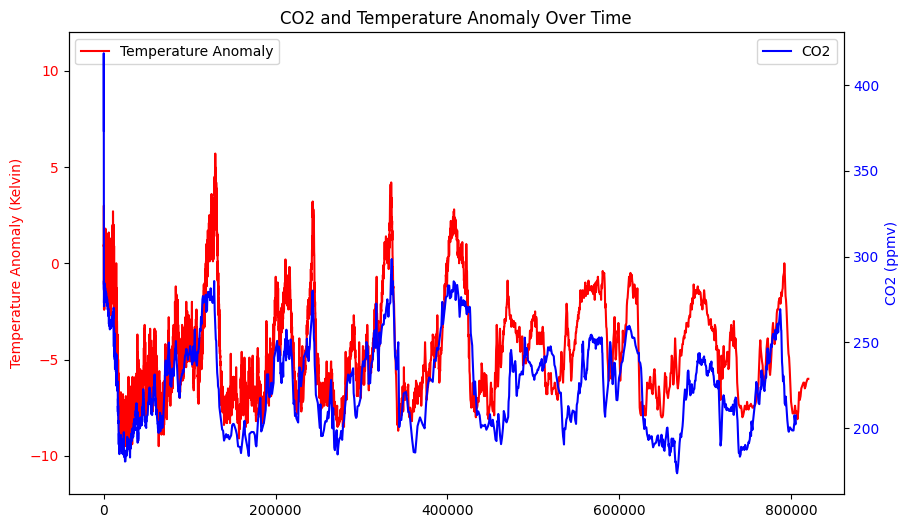

In [30]:
# Create a new figure with shared x-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Temperature Anomaly data on the left y-axis
ax1.plot(temp_df['Gasage (yr BP)'], temp_df['Temperature Anomaly (Kelvin)'], label='Temperature Anomaly', color='red')
ax1.set_ylabel('Temperature Anomaly (Kelvin)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Set y-axis limits for the temperature axis
ax1.set_ylim(-12, 12)

# Create a second y-axis for CO2 data
ax2 = ax1.twinx()
ax2.plot(merged_data['Gasage (yr BP)'], merged_data['CO2 (ppmv)'], label='CO2', color='blue')
ax2.set_xlabel('Gasage (yr BP)')
ax2.set_ylabel('CO2 (ppmv)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('CO2 and Temperature Anomaly Over Time')
plt.show()

The ice cores over the last 800kyrs reveal a very tight connection between temperature and greenhouse gas levels through the ice age cycles. Natural changes in carbon dioxide levels are directly related to past increases and decreases of global temperatures. Temperature and CO2 have fluctuated together over ice ages and warm periods, called interglacials [11]. The level of CO2 in the atmosphere reached an all time high in recent years. For the first time in history, it has reached 400 parts per million at the Mauna Loa Observatory in Hawaii. There are several factors that have caused this increase, these include deforestation and from burning coal, oil, and natural gas. 

In [89]:
# Extract time and CO2 concentration values
# https://stackoverflow.com/questions/30209779/fourier-transform-in-python
time = co2_data['Gasage (yr BP)']
co2_values = co2_data['CO2 (ppmv)']

# Perform Fourier Transform
co2_fft = np.fft.fft(co2_values)

# Calculate frequencies corresponding to FFT result
co2_freq = np.fft.fftfreq(len(co2_fft), d=(time[1] - time[0]))

In [92]:
# Extract time and Temperature values
temp_time = temp_df['Gasage (yr BP)']
temp_values = temp_df['Temperature Anomaly (Kelvin)']

# Perform Fourier Transform
temp_fft = np.fft.fft(temp_values)

# Calculate frequencies corresponding to FFT result
temp_freq = np.fft.fftfreq(len(temp_fft), d=(temp_time[1] - temp_time[0]))

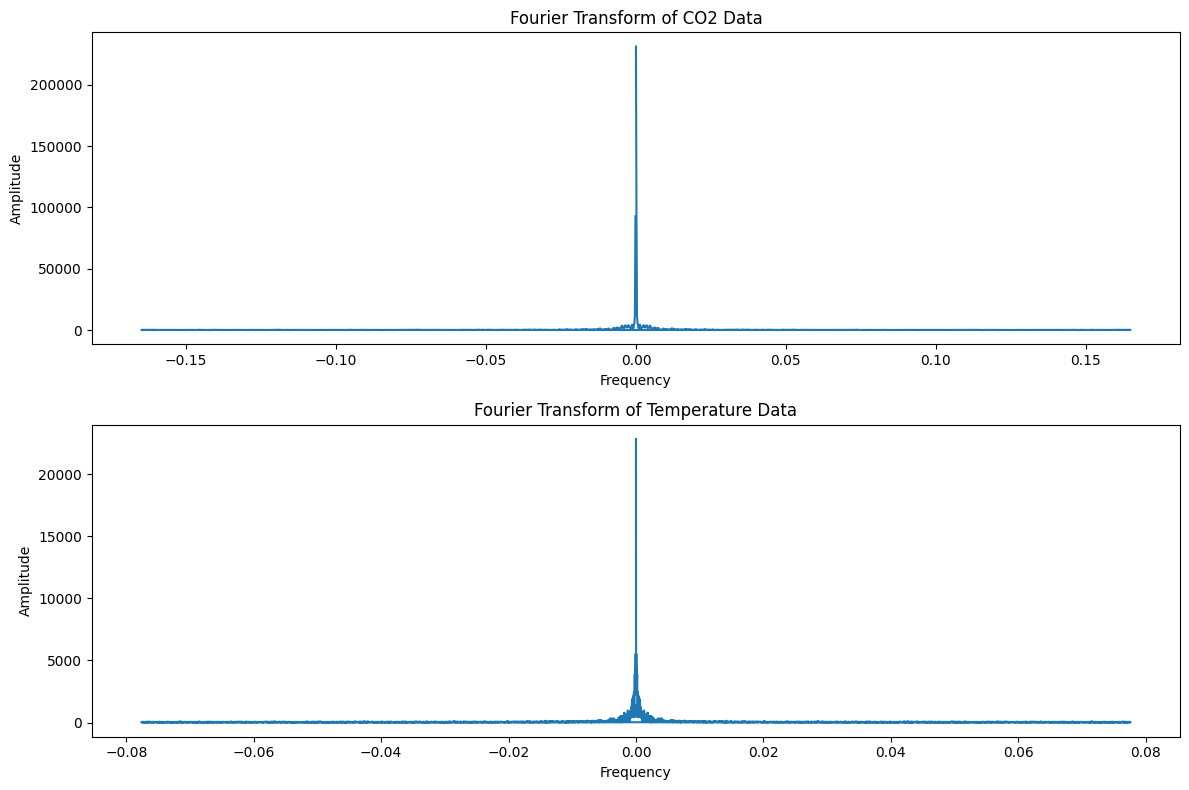

In [95]:
# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(co2_freq, np.abs(co2_fft))
plt.title('Fourier Transform of CO2 Data')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(temp_freq, np.abs(temp_fft))
plt.title('Fourier Transform of Temperature Data')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

The spike at 0Hz for both the temperature and the CO2 concentration represents the baseline of each. Higher amplitudes suggest a more significant and constant baseline. This result also may be cause of biases that may affect the Fourier transform.

Multiple frequency components or spikes are expected to be seen in the Fourier transform of historical CO2 and temperature data, particularly when considering the influence of natural climate cycles such as ice ages. There have been 5 to 6 estimated glacial and interglacial periods in history. The Earth's climate has experienced cyclic variations over geological time scales. During these ice ages, the caron dioxode levels and temperature levels tend to be lower, and during the interglacial periods both carbon dioxide and temperature tend to be higher. Currently we are in the middle of an interglacial period. Therefore, when a Fourier transform is applied to both the historical data of CO2 and Temperature, the graphs are excpected to have a few peaks corresponding to the periodicity of these climate cycles.

### CH4 Analysis

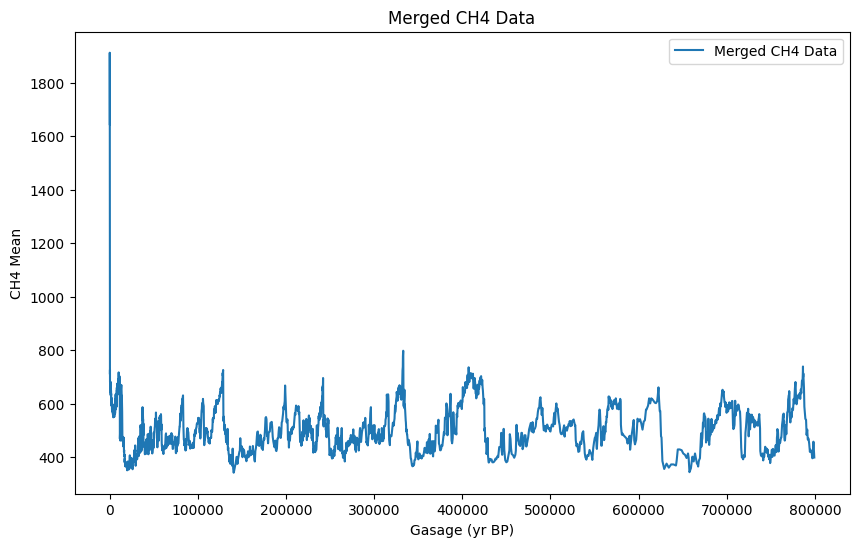

In [32]:
# Plot the merged CH4 data.
plt.figure(figsize=(10, 6))
plt.plot(merged_CH4_data['Gasage (yr BP)'], merged_CH4_data['CH4 Mean'], label='Merged CH4 Data')
plt.xlabel('Gasage (yr BP)')
plt.ylabel('CH4 Mean')
plt.title('Merged CH4 Data')
plt.legend()
plt.show()

### Irish Context Analysis

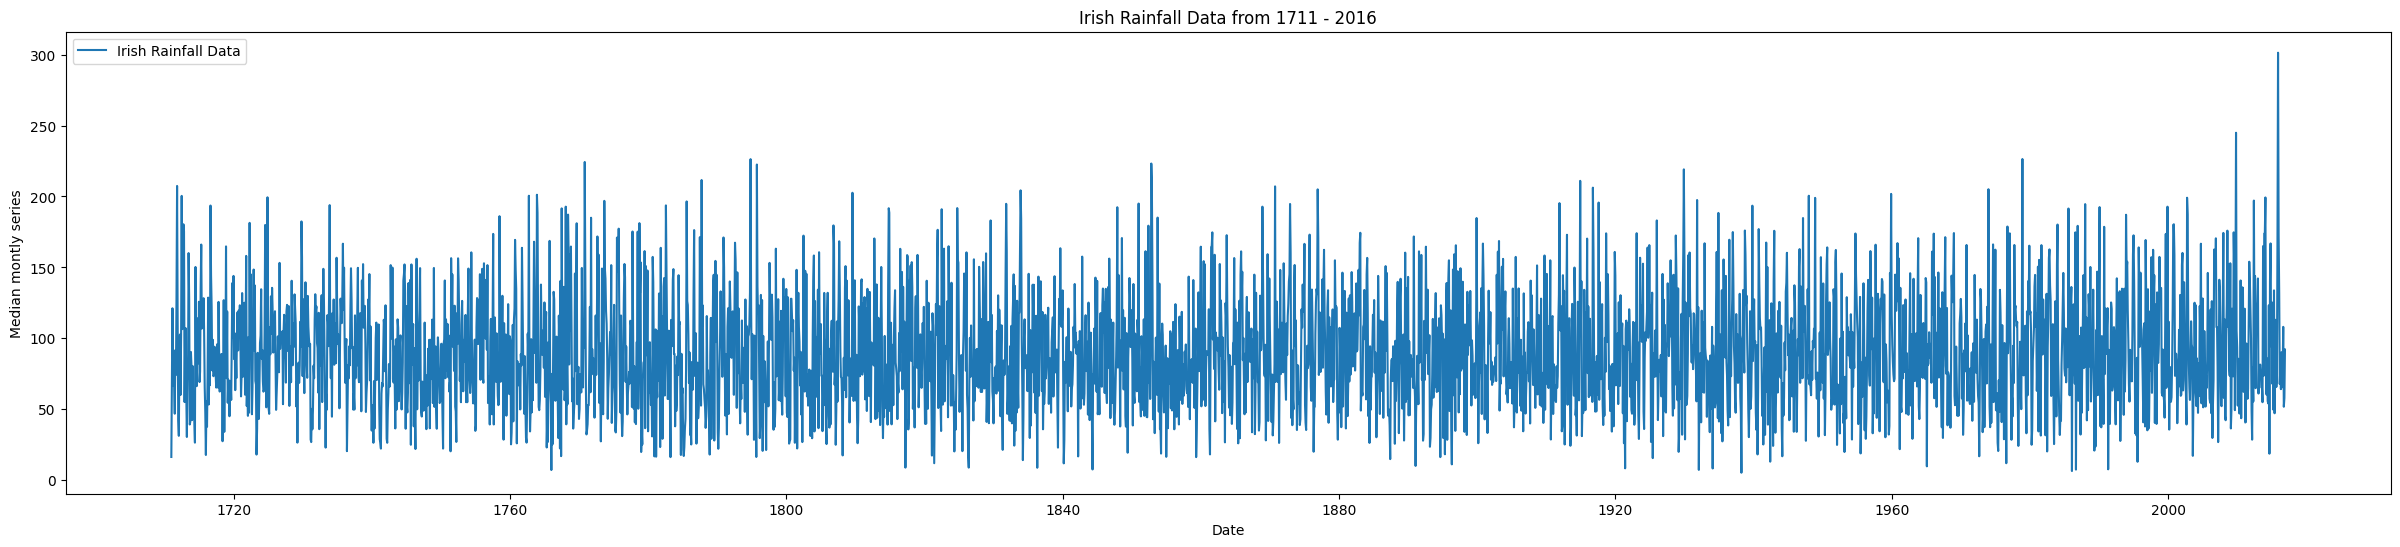

In [33]:
# Plot Irish Rainfall data.
plt.figure(figsize=(30, 6))
plt.plot(rainfall_data['Date'], rainfall_data['Median montly series'], label='Irish Rainfall Data')
plt.xlabel('Date')
plt.ylabel('Median montly series')
plt.title('Irish Rainfall Data from 1711 - 2016')
plt.legend()
plt.show()

#### Moving Average of Rainfall
The moving average allows the short-term fluctuations or noise in time series data to be smoothed out. Trends in the data can be found more easily. It is a useful tool to help anaylyze seasonality patterns in the data, helping to identify recurring cycles. The choice of the window size is a critical factor. A larger window size results in smoother trends but may overlook short-term variations, while a smaller window size captures more short-term changes but may be sensitive to noise. 

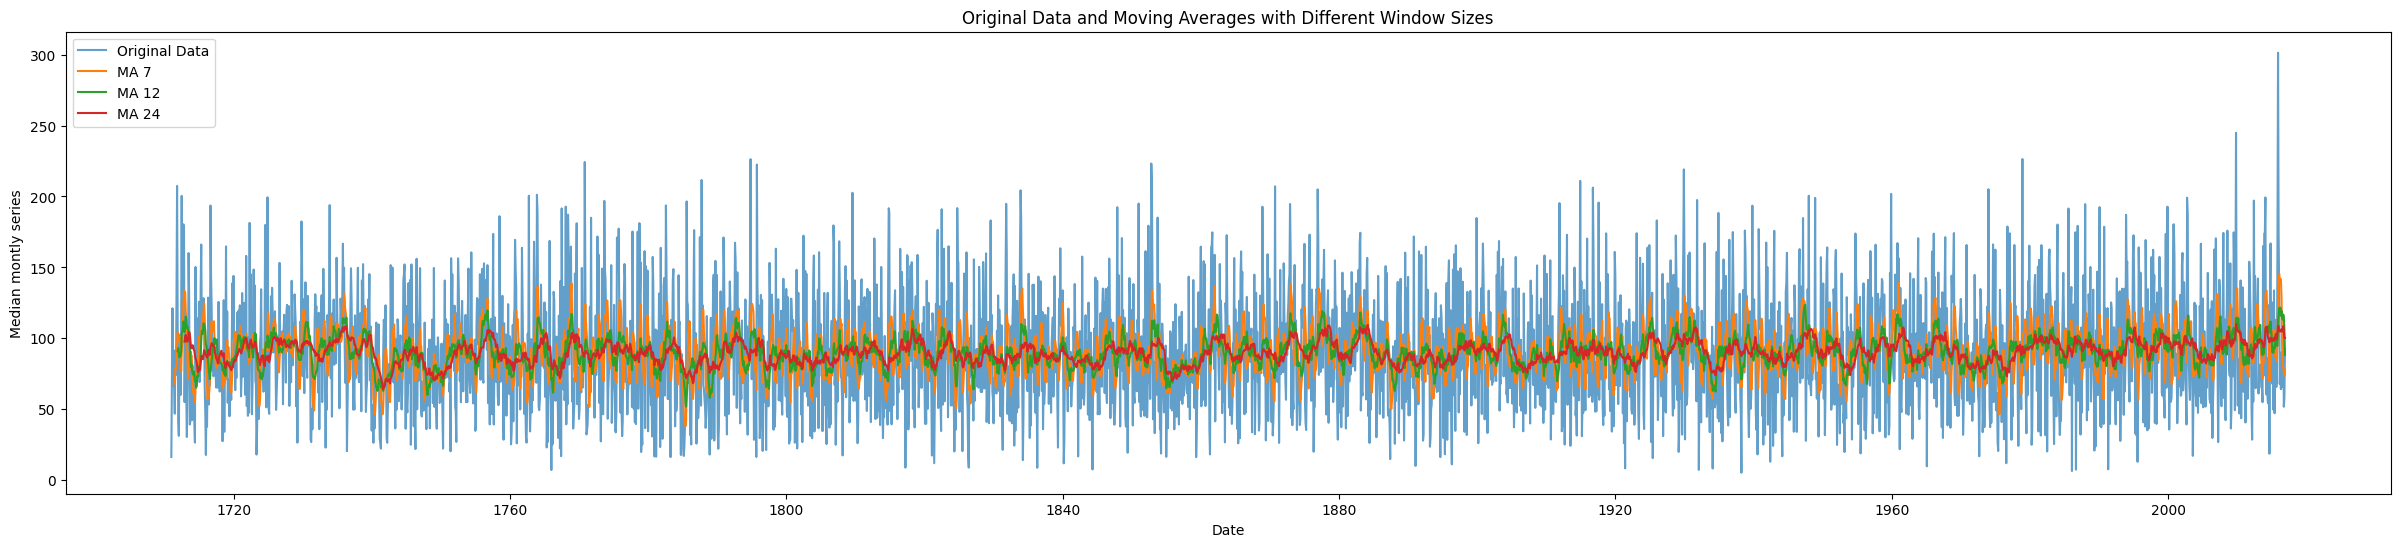

In [34]:
# Visualize original data and moving average with different window sizes
# https://mins.space/blog/2020-06-29-moving-average-effect-window-size/
plt.figure(figsize=(30, 6))
plt.plot(rainfall_data['Date'], rainfall_data['Median montly series'], label='Original Data', alpha=0.7)
for window_size in [7, 12, 24]:
    rainfall_data[f'MA_{window_size}'] = rainfall_data['Median montly series'].rolling(window=window_size).mean()
    plt.plot(rainfall_data['Date'], rainfall_data[f'MA_{window_size}'], label=f'MA {window_size}')
plt.xlabel('Date')
plt.ylabel('Median montly series')
plt.title('Original Data and Moving Averages with Different Window Sizes')
plt.legend()
plt.show()

In [35]:
window_size = 24
rainfall_data['MA'] = rainfall_data['Median montly series'].rolling(window=window_size).mean()

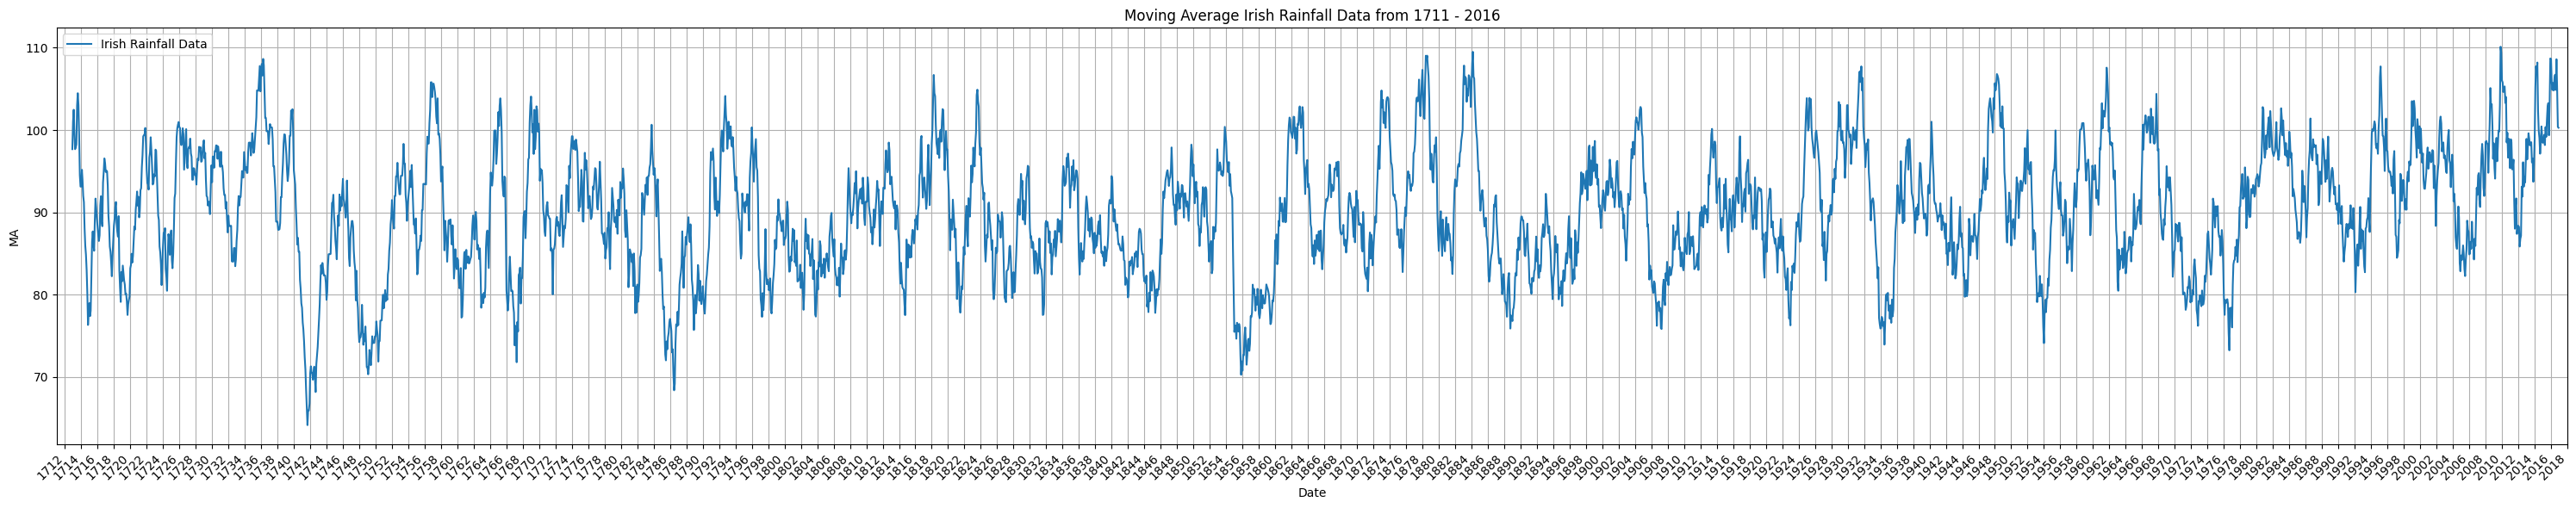

In [36]:
# Plot Irish Rainfall data.
plt.figure(figsize=(30, 6))
plt.plot(rainfall_data['Date'], rainfall_data['MA'], label='Irish Rainfall Data')

# Set major locator to YearLocator.
# https://matplotlib.org/stable/api/dates_api.html#matplotlib.dates.YearLocator
plt.gca().xaxis.set_major_locator(YearLocator(base=2))

# Format the x-axis labels to show only the years.
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

# Rotate x-axis labels for better readability.
plt.xticks(rotation=45, ha='right')

# Set x-axis limits to start in 1710 and finish in 2017.
plt.xlim(pd.Timestamp('1711-01-01'), pd.Timestamp('2018-01-01'))

# Add a grid
plt.grid(True)

plt.xlabel('Date')
plt.ylabel('MA')
plt.title('Moving Average Irish Rainfall Data from 1711 - 2016')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent cropping of labels
plt.show()

The data above must be treated with caution as it consists of two different datasets merged together. Given the variety of sources used, changing measurement apparatus and techniques, the changing number of contributing sources and stations, together with the difficulty in penetrating the full details of methods used by Jenkinson et al. (1979), the pre-1850 record can not be considered entirely reliable [12]. For example, rain gauges during the 1700s and early 1800s were experimental and largely unrecognisable by modern standards. The gauge used by Thomas Neve in Derry is described as being 12 inches in diameter and fixed to the ridge of his house, draining through a funnel and tin pipe into a loft and collected by a large glass bottle [12]. 

The most recent years appear to be the wettest years in the last 300 years. Climate change can alter rainfall patterns. The data earlier in the notebook shows the increases on CO2, CH4, and temperature. Hence, an increased amount of rainfall is as expected. There are definite patterns to be seen throughout the 300 years. It would be expected that the winters would be slightly wetter than the summers. 

#### Seasons 
Splitting the rainfall data into the different seasons (*Spring*, *Summer*, *Autumn*, and *Winter*) can allow for a more detailed analysis of climate patterns and trends throughout the years. The seasons have distinct meteorological characteristics. This will provide insights into the seasonal variability of rainfall.

In [37]:
# Define functions to classify months into seasons
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

In [38]:
# Extract year and month from the 'Date' column
rainfall_data['Year'] = rainfall_data['Date'].dt.year
rainfall_data['Month'] = rainfall_data['Date'].dt.month

# Apply the get_season function to create a new 'Season' column
rainfall_data['Season'] = rainfall_data['Month'].apply(get_season)

# Now you can filter the data based on the desired season
summer_data = rainfall_data[rainfall_data['Season'] == 'Summer']
autumn_data = rainfall_data[rainfall_data['Season'] == 'Autumn']
spring_data = rainfall_data[rainfall_data['Season'] == 'Spring']
winter_data = rainfall_data[rainfall_data['Season'] == 'Winter']

#### Summary Statitics

In [39]:
# Define a function to calculate and print summary statistics
def calculate_statistics(season_name, season_data):
    print(f"\nSummary statistics for {season_name}:\n")
    print(season_data.describe())
    print("\n")

In [40]:
# Calculate and print statistics for Summer and Autumn
calculate_statistics("Summer", summer_data['Median montly series'])
calculate_statistics("Autumn", autumn_data['Median montly series'])


Summary statistics for Summer:

count    918.000000
mean      87.143246
std       37.390990
min        8.400000
25%       59.800000
50%       83.050000
75%      109.500000
max      202.600000
Name: Median montly series, dtype: float64



Summary statistics for Autumn:

count    918.000000
mean     103.654466
std       39.925181
min        7.500000
25%       72.250000
50%      102.350000
75%      130.900000
max      244.900000
Name: Median montly series, dtype: float64




In [41]:
# Calculate and print statistics for Spring and Winter
calculate_statistics("Spring", spring_data['Median montly series'])
calculate_statistics("Winter", winter_data['Median montly series'])


Summary statistics for Spring:

count    918.000000
mean      71.767756
std       30.681332
min        5.300000
25%       48.700000
50%       69.200000
75%       93.625000
max      184.800000
Name: Median montly series, dtype: float64



Summary statistics for Winter:

count    918.000000
mean      97.660022
std       41.480310
min        6.500000
25%       67.325000
50%       94.900000
75%      123.275000
max      301.300000
Name: Median montly series, dtype: float64




The summary statitics above provides an insight into the variability of rainfall in the different seasons. The main obseravtions made are that Autumn has the highest mean rainfall (103.65mm), followed by Winter (97.66 mm), Summer (87.14 mm), and Spring (71.77 mm). These results indiacte that Autumn tends to have the highest mean rainfall, while Spring has the lowest. Winter has the highest variability in rainfall (41.48 mm), followed by Autumn (39.93 mm), Summer (37.39 mm), and Spring (30.68 mm). Winter has the highest maximum rainfall (301.3 mm), while Summer has the lowest maximum rainfall (202.6 mm). Spring has the lowest minimum rainfall (5.3 mm). Winter exhibits the highest variability and maximum rainfall, possibly indicating more unpredictable and extreme weather conditions.

***

## Temperature Anomaly Prediction

In [53]:
# Extract the first 50 data points
recent_temp_df = temp_df[:30].copy()

In [74]:
# Convert 'Gasage (yr BP)' to datetime
recent_temp_df['Datetime'] = pd.to_datetime(reference_year - recent_temp_df['Gasage (yr BP)'], format='%Y', errors='coerce')

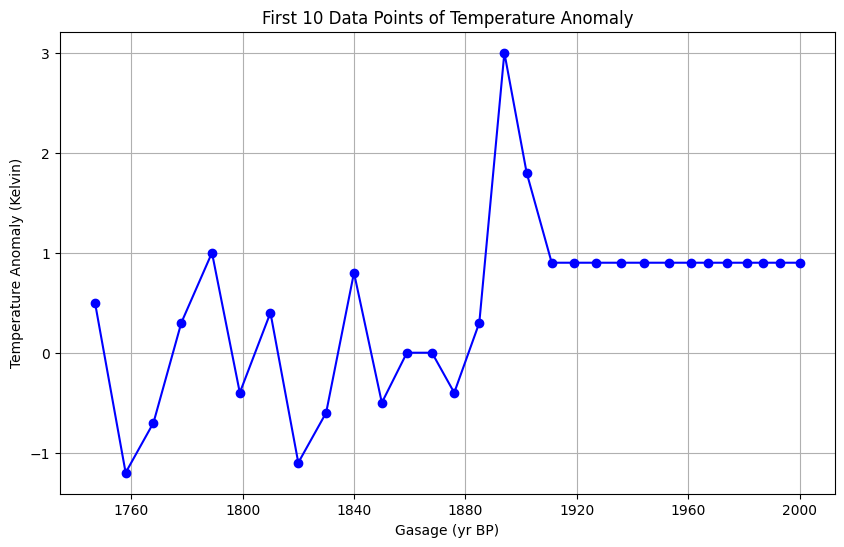

In [56]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(recent_temp_df['Datetime'], recent_temp_df['Temperature Anomaly (Kelvin)'], marker='o', linestyle='-', color='blue')
plt.xlabel('Datetime')
plt.ylabel('Temperature Anomaly (Kelvin)')
plt.title('First 30 Data Points of Temperature Anomaly')
plt.grid(True)
plt.show()

In [60]:
# Feature selection: Using 'Gasage (yr BP)' as the predictor variable
X = recent_temp_df[['Datetime']].values.reshape(-1, 1)
y = recent_temp_df['Temperature Anomaly (Kelvin)'].values

In [75]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [77]:
# Create a linear regression model
model = LinearRegression()

In [84]:
# Train the model
model.fit(X_train, y_train)

LinearRegression()

The straight line might mean the model is over simplified or maybe there isnt a linear relationship. 

***

## Conclusion
In conclusion, climate change can lead to shifts in temperature, atmospheric circulation, and precipitation patterns. The natural climate cycles of Earth's climate, ocean circulation, and the carbon cycle have all contributed to the glacial and interglacial periods Earth has experienced over the last 800kyrs. However, in recent years there has been an exponetial growth in CO2 concentrations and temperature. This is due to human activity, particularly the burning of fossil fuels, have significantly increased atmospheric CO2 concentrations.

***

## References
[1] *Paleoclimatology*, *National Geographic Society*, https://education.nationalgeographic.org/resource/paleoclimatology-RL/
<br>
[2] *Ice Age*, *HISTORY.COM EDITORS*, https://www.history.com/topics/pre-history/ice-age
<br>
[3] *Global Monitoring Laboratory*, *Dr. Pieter Tans* and *Dr. Ralph Keeling*, https://gml.noaa.gov/ccgg/trends/data.html
<br>
[4] *Mauna Loa Observatory*, *National Geographic Society*, https://education.nationalgeographic.org/resource/mauna-loa-observatory/
<br>
[5] *Climate Math*, *Let’s Talk Science*, https://letstalkscience.ca/educational-resources/backgrounders/climate-math
<br>
[6] *EPICA Dome C Ice Core 800KYr Deuterium Data and Temperature Estimates*, *Jouzel, J.*, https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc3deuttemp2007.txt
<br>
[7] *EPICA Dome C Ice Core 800KYr Methane Data*, *Loulergue, L., A. Schilt, R. Spahni, V. Masson-Delmotte, T. Blunier, 
B. Lemieux, J.-M. Barnola, D. Raynaud, T.F. Stocker, and J. Chappellaz*, https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc-ch4-2008.txt
<br>
[8] *Methane*, *The Editors of Encyclopaedia Britannica*, https://www.britannica.com/science/methane
<br>
[9] *Trends in Atmospheric Methane*, *Lan, X., K.W. Thoning, and E.J. Dlugokencky*, https://gml.noaa.gov/webdata/ccgg/trends/ch4/ch4_annmean_gl.txt
<br>
[10] *Long Term Data Sets*, *MET Eireann*, https://www.met.ie/climate/available-data/long-term-data-sets/
<br>
[11] *The three-minute story of 800,000 years of climate change with a sting in the tail*, *Ben Henley and Nerilie Abram*, https://theconversation.com/the-three-minute-story-of-800-000-years-of-climate-change-with-a-sting-in-the-tail-73368
<br>
[12] *A 305-year continuous monthly rainfall series for the island
of Ireland (1711–2016)*, *Conor Murphy1
, Ciaran Broderick1
, Timothy P. Burt2
, Mary Curley3
, Catriona Duffy1
, Julia Hall4
, Shaun Harrigan5
,
Tom K. R. Matthews6
, Neil Macdonald7
, Gerard McCarthy1
, Mark P. McCarthy8
, Donal Mullan9
, Simon Noone1
,
Timothy J. Osborn10, Ciara Ryan1
, John Sweeney1
, Peter W. Thorne1
, Seamus Walsh3
, and Robert L. Wilby11*, https://mural.maynoothuniversity.ie/9352/1/CM_305%20year.pdf
<br>

***
# End